In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import mdtraj as md
import os
import sys
import matplotlib.cm as cm 

import gzip
from Bio.PDB import PDBParser
import glob

**Add Ca2+ given EF-hand residue ids**

In [2]:
files = glob.glob('ini_md/*')
ef1 = np.loadtxt('EF1.txt')
ef2 = np.loadtxt('EF2.txt')
print(ef1,ef2)
for file in files:
    traj = md.load(file)
    oxy1 = []
    for ii in ef1:
        oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
    oxy1 = np.concatenate(oxy1)
    ca1 = np.mean(traj.xyz[0,oxy1,:], axis=0)*10
    ca1 = [f"{num:.3f}" for num in ca1]
    
    oxy2 = []
    for ii in ef2:
        oxy2.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
    oxy2 = np.concatenate(oxy2)
    ca2 = np.mean(traj.xyz[0,oxy2,:], axis=0)*10
    ca2 = [f"{num:.3f}" for num in ca2]
    
    oxy1 = []
    for ii in ef1:
        oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
    oxy1 = np.concatenate(oxy1)
    ca3 = np.mean(traj.xyz[0,oxy1,:], axis=0)*10
    ca3 = [f"{num:.3f}" for num in ca3]
    
    oxy2 = []
    for ii in ef2:
        oxy2.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
    oxy2 = np.concatenate(oxy2)
    ca4 = np.mean(traj.xyz[0,oxy2,:], axis=0)*10
    ca4 = [f"{num:.3f}" for num in ca4]

    
    with open(file,'r') as fopen:
        lines = fopen.readlines()
    data=''
    aid=1
    for line in lines:
        if  (line.split()[0] == 'ATOM') or (line.split()[0] == 'TER'):
            atom = '        ' + str(aid)
            data += line[0:4] + atom[-7:] + line[11:]
            aid += 1
    atom = '        ' + str(aid)
    X = '                 ' + str(ca1[0])
    Y = '                 ' + str(ca1[1])
    Z = '                 ' + str(ca1[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA C   1' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    aid += 1
    
    atom = '        ' + str(aid)
    X = '                 ' + str(ca2[0])
    Y = '                 ' + str(ca2[1])
    Z = '                 ' + str(ca2[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA C   2' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    aid += 1
    
    atom = '        ' + str(aid)
    data += 'TER ' + atom[-7:] + '\n' 
    aid += 1
    
    atom = '        ' + str(aid)
    X = '                 ' + str(ca3[0])
    Y = '                 ' + str(ca3[1])
    Z = '                 ' + str(ca3[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA D   1' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    aid += 1
    
    atom = '        ' + str(aid)
    X = '                 ' + str(ca4[0])
    Y = '                 ' + str(ca4[1])
    Z = '                 ' + str(ca4[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA D   2' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    data += 'END' 
    
    outputfile = file[:-4] +'_ca.pdb'
    with open(outputfile,'w') as fwrite:
        fwrite.writelines(data)

[19. 22. 24. 27. 32.] [62. 64. 66. 68. 73.]


**Determine ion-Oxygen pairs to constrain**

/home/xgu/miniconda3/envs/openmm/lib/python3.10/site-packages/mdtraj/formats/pdb/pdbfile.py:200: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


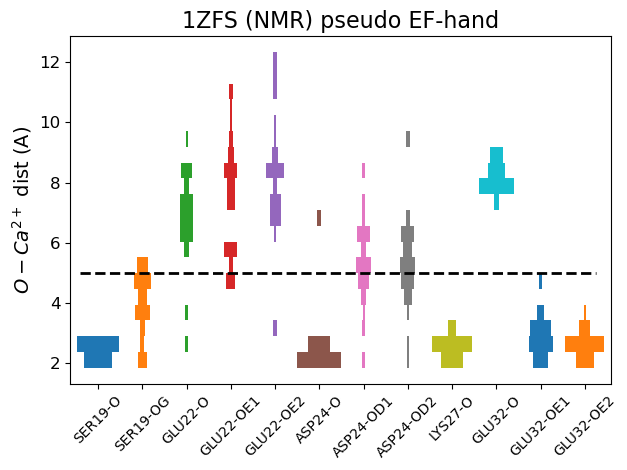

In [2]:
traj = md.load('1zfs.pdb')
ions = traj.top.select(f'resname CA')
ef1 = np.loadtxt('EF1.txt')
distances=[]

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[1], a2] for a2 in oxy1],periodic=False).tolist())

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[3], a2] for a2 in oxy1],periodic=False).tolist())
distances = np.concatenate(distances)*10
oxy_l = [f"{traj.top.atom(oxy)}" for oxy in oxy1]

data_sets = distances.T
labels = oxy_l

number_of_bins = 20
hist_range = (np.min(data_sets), np.max(data_sets))
binned_data_sets = [
    np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    for d in data_sets
]
binned_maximums = np.max(binned_data_sets, axis=1)
x_locations = np.arange(0, np.max(binned_maximums)*(len(data_sets)+0.2), np.max(binned_maximums))

# The bin_edges are the same for all of the histograms
bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
heights = np.diff(bin_edges)
centers = bin_edges[:-1] + heights / 2

# Cycle through and plot each histogram
fig, ax = plt.subplots()
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    lefts = x_loc - 0.5 * binned_data
    ax.barh(centers, binned_data, height=heights, left=lefts)

ax.set_xticks(x_locations[:12], labels, rotation=45,fontsize=10)
ax.set_ylabel(r"$O-Ca^{2+}$ dist (A)", fontsize=14)
plt.yticks(fontsize=12)
plt.xlim(-15,278)
plt.hlines(5,-10,270,'k','--',linewidth=2)
plt.title(f"1ZFS (NMR) pseudo EF-hand", fontsize=16)
plt.tight_layout()
# plt.savefig(f"1zfs_EF1.png",dpi=300)

In [4]:
', '.join(labels)

'SER19-O, SER19-OG, GLU22-O, GLU22-OE1, GLU22-OE2, ASP24-O, ASP24-OD1, ASP24-OD2, LYS27-O, GLU32-O, GLU32-OE1, GLU32-OE2'

# traj = md.load('1zfs.pdb')
ions = traj.top.select(f'resname CA')
ef1 = np.loadtxt('EF2.txt')
distances=[]

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[0], a2] for a2 in oxy1],periodic=False).tolist())

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[2], a2] for a2 in oxy1],periodic=False).tolist())
distances = np.concatenate(distances)*10
oxy_l = [f"{traj.top.atom(oxy)}" for oxy in oxy1]

data_sets = distances.T
labels = oxy_l

number_of_bins = 20
hist_range = (np.min(data_sets), np.max(data_sets))
binned_data_sets = [
    np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    for d in data_sets
]
binned_maximums = np.max(binned_data_sets, axis=1)
x_locations = np.arange(0, np.max(binned_maximums)*(len(data_sets)+0.2), np.max(binned_maximums))

# The bin_edges are the same for all of the histograms
bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
heights = np.diff(bin_edges)
centers = bin_edges[:-1] + heights / 2

# Cycle through and plot each histogram
fig, ax = plt.subplots()
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    lefts = x_loc - 0.5 * binned_data
    ax.barh(centers, binned_data, height=heights, left=lefts)

ax.set_xticks(x_locations[:14], labels, rotation=45,fontsize=10)
ax.set_ylabel(r"$O-Ca^{2+}$ dist (A)", fontsize=14)
plt.yticks(fontsize=12)
# plt.xlim(-15,278)
plt.hlines(5,-10,480,'k','--',linewidth=2)
plt.title(f"1ZFS (NMR) typical EF-hand", fontsize=16)
plt.tight_layout()
# plt.savefig(f"1zfs_EF2.png",dpi=300)

In [6]:
', '.join(labels)

'ASP62-O, ASP62-OD1, ASP62-OD2, ASN64-O, ASN64-OD1, ASP66-O, ASP66-OD1, ASP66-OD2, GLU68-O, GLU68-OE1, GLU68-OE2, GLU73-O, GLU73-OE1, GLU73-OE2'

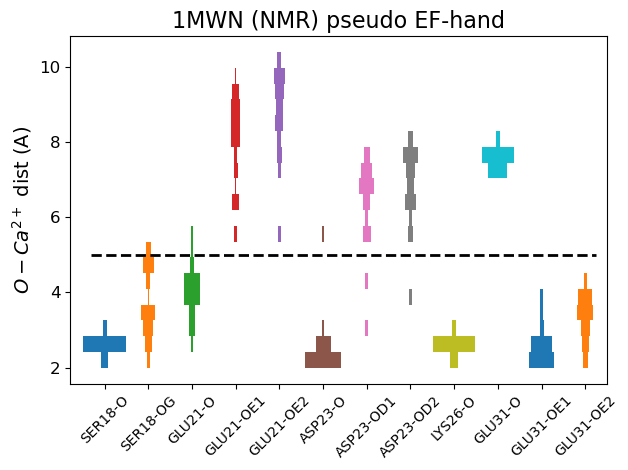

In [5]:
traj = md.load('1mwn.pdb')
ions = traj.top.select(f'resname CA')
ef1 = np.loadtxt('EF1.txt')-1
distances=[]

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[0], a2] for a2 in oxy1],periodic=False).tolist())

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[2], a2] for a2 in oxy1],periodic=False).tolist())
distances = np.concatenate(distances)*10
oxy_l = [f"{traj.top.atom(oxy)}" for oxy in oxy1]

data_sets = distances.T
labels = oxy_l

number_of_bins = 20
hist_range = (np.min(data_sets), np.max(data_sets))
binned_data_sets = [
    np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    for d in data_sets
]
binned_maximums = np.max(binned_data_sets, axis=1)
x_locations = np.arange(0, np.max(binned_maximums)*(len(data_sets)+0.2), np.max(binned_maximums))

# The bin_edges are the same for all of the histograms
bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
heights = np.diff(bin_edges)
centers = bin_edges[:-1] + heights / 2

# Cycle through and plot each histogram
fig, ax = plt.subplots()
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    lefts = x_loc - 0.5 * binned_data
    ax.barh(centers, binned_data, height=heights, left=lefts)

ax.set_xticks(x_locations[:12], labels, rotation=45,fontsize=10)
ax.set_ylabel(r"$O-Ca^{2+}$ dist (A)", fontsize=14)
plt.yticks(fontsize=12)
plt.xlim(-25,368)
plt.hlines(5,-10,360,'k','--',linewidth=2)
plt.title(f"1MWN (NMR) pseudo EF-hand", fontsize=16)
plt.tight_layout()
plt.savefig(f"1MWN_EF1.png",dpi=300)

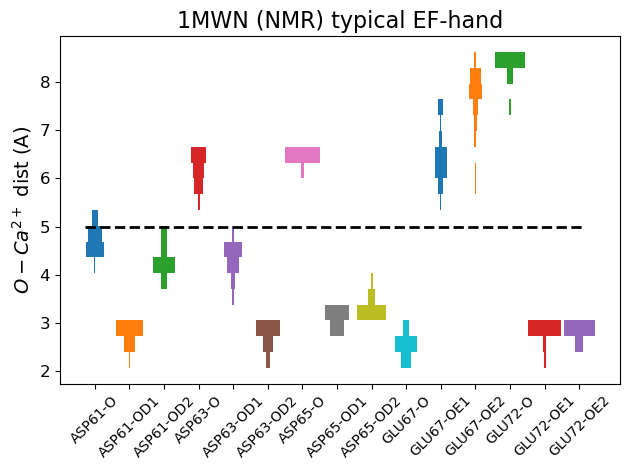

In [6]:
traj = md.load('1mwn.pdb')
ions = traj.top.select(f'resname CA')
ef1 = np.loadtxt('EF2.txt')-1
distances=[]

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[1], a2] for a2 in oxy1],periodic=False).tolist())

oxy1 = []
for ii in ef1:
    oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
oxy1 = np.concatenate(oxy1)
distances.append(md.compute_distances(traj, [[ions[3], a2] for a2 in oxy1],periodic=False).tolist())
distances = np.concatenate(distances)*10
oxy_l = [f"{traj.top.atom(oxy)}" for oxy in oxy1]

data_sets = distances.T
labels = oxy_l

number_of_bins = 20
hist_range = (np.min(data_sets), np.max(data_sets))
binned_data_sets = [
    np.histogram(d, range=hist_range, bins=number_of_bins)[0]
    for d in data_sets
]
binned_maximums = np.max(binned_data_sets, axis=1)
x_locations = np.arange(0, np.max(binned_maximums)*(len(data_sets)+0.2), np.max(binned_maximums))

# The bin_edges are the same for all of the histograms
bin_edges = np.linspace(hist_range[0], hist_range[1], number_of_bins + 1)
heights = np.diff(bin_edges)
centers = bin_edges[:-1] + heights / 2

# Cycle through and plot each histogram
fig, ax = plt.subplots()
for x_loc, binned_data in zip(x_locations, binned_data_sets):
    lefts = x_loc - 0.5 * binned_data
    ax.barh(centers, binned_data, height=heights, left=lefts)

ax.set_xticks(x_locations[:15], labels, rotation=45,fontsize=10)
ax.set_ylabel(r"$O-Ca^{2+}$ dist (A)", fontsize=14)
plt.yticks(fontsize=12)
# plt.xlim(-15,278)
plt.hlines(5,-10,510,'k','--',linewidth=2)
plt.title(f"1MWN (NMR) typical EF-hand", fontsize=16)
plt.tight_layout()
plt.savefig(f"1mwn_EF2.png",dpi=300)

In [4]:
# Final ion-oxygen list to constrain
oxy_EF1=['19-O','27-O','32-OE1','32-OE2']  ## resSeq-name
oxy_EF2=['62-OD1','66-OD2','68-O','73-OE1','73-OE2'] ## resSeq-name

def ion_oxy_pairs(top):
    pairs = []
    ca1 = top.select('resSeq 1 and element Ca and chainid 2')[0]
    for oxy in oxy_EF1:
        lls = oxy.split('-')
        oid = top.select(f'resSeq {lls[0]} and name {lls[1]} and chainid 0')[0]
        pairs.append([ca1, oid])

    ca1 = top.select('resSeq 2 and element Ca and chainid 2')[0]
    for oxy in oxy_EF2:
        lls = oxy.split('-')
        oid = top.select(f'resSeq {lls[0]} and name {lls[1]} and chainid 0')[0]
        pairs.append([ca1, oid])

    ca1 = top.select('resSeq 1 and element Ca and chainid 3')[0]
    for oxy in oxy_EF1:
        lls = oxy.split('-')
        oid = top.select(f'resSeq {lls[0]} and name {lls[1]} and chainid 1')[0]
        pairs.append([ca1, oid])

    ca1 = top.select('resSeq 2 and element Ca and chainid 3')[0]
    for oxy in oxy_EF2:
        lls = oxy.split('-')
        oid = top.select(f'resSeq {lls[0]} and name {lls[1]} and chainid 1')[0]
        pairs.append([ca1, oid])
    return pairs

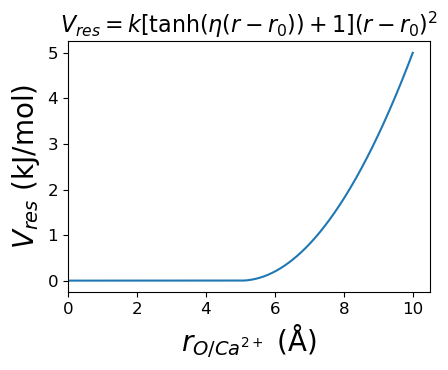

In [7]:
# Potential to constrain ion-oxygen distance
r0 = 5.0  # Ångström
k = 10.0  # kJ/mol/nm^2
eta = 100.0  # dimensionless

# Range of r values
r = np.linspace(0, 10, 500)  # r from 0 to 10 Å

# Convert Ångström to nm (1 Å = 0.1 nm)
r_nm = r * 0.1

# Potential function
V = k * (np.tanh(eta * (r_nm - r0 * 0.1)) + 1) * (r_nm - r0 * 0.1) ** 2

# Plotting
plt.figure(figsize=(4.5,3.8))
plt.plot(r, V)
plt.xlabel(r'$r_{O/Ca^{2+}}$ (Å)',fontsize=20)
plt.ylabel(r'$V_{res}$ (kJ/mol)',fontsize=20)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlim([0,10.5])
plt.title(r'$V_{res} = k [\tanh(\eta (r-r_0)) + 1](r-r_0)^2$',y=1.0,fontsize=16)
plt.tight_layout()
plt.savefig(f"V_res.png",dpi=300)   

**Remove unbiased MD trajs with incorrect Ca2+ EF-hand coordination**

In [34]:
trajs = glob.glob("unbiasedMD/visual/*.pdb")
pdbs = []
coor_means = []
for traj_file in trajs:
    traj = md.load(traj_file)
    ca_oxy_pairs = ion_oxy_pairs(traj.top)
    dist = md.compute_distances(traj,ca_oxy_pairs,periodic=True)
    pdbs.append(traj_file.split('/')[-1][:-4])
    coor_means.append(np.mean(dist,axis=0)*10)

In [59]:
discard = []
for i in range(len(trajs)):
    print(pdbs[i], len(np.where(coor_means[i]>5)[0]))
    if len(np.where(coor_means[i]>5)[0]) > 2 :
        discard.append(pdbs[i])

S100A1_1_ca 2
S100A1_232_ca 2
S100A1_240_ca 1
S100A1_243_ca 0
S100A1_249_ca 2
S100A1_252_ca 2
S100A1_253_ca 1
S100A1_255_ca 1
S100A1_256_ca 1
S100A1_257_ca 5
S100B_0_ca 0
S100B_105_ca 3
S100B_113_ca 2
S100B_116_ca 2
S100B_137_ca 2
S100B_149_ca 0
S100B_155_ca 0
S100B_157_ca 0
S100B_161_ca 0
S100B_162_ca 0
S100B_163_ca 1
S100B_164_ca 3
S100B_165_ca 1
S100B_166_ca 9
S100B_1_ca 2


In [60]:
discard

['S100A1_257_ca', 'S100B_105_ca', 'S100B_164_ca', 'S100B_166_ca']

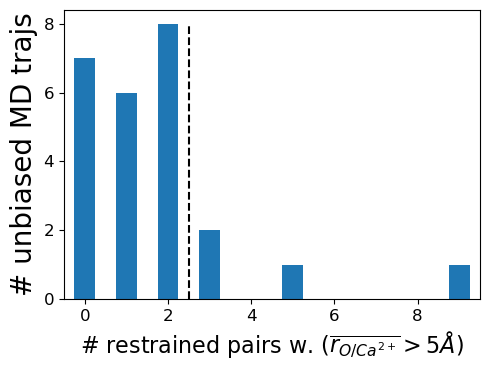

In [86]:
n_incorrect = []
for i in range(len(trajs)):
    n_incorrect.append(len(np.where(coor_means[i]>5)[0]))
    
plt.figure(figsize=(5,3.8))
plt.hist(n_incorrect,bins=np.arange(-0.25,9.75,0.5))
plt.vlines(2.5,0,8,'k', "dashed")
plt.xlabel(r'# restrained pairs w. ($\overline{r_{O/Ca^{2+}}}>5\AA$)',fontsize=16)
plt.ylabel(r'# unbiased MD trajs',fontsize=20)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.xlim([-0.5,9.5])
plt.tight_layout()
plt.savefig(f"discard.png",dpi=300)   


In [5]:
# for peptide induced fit effect validation
# files = glob.glob('S100A_Peptide_remove/ini_md/*')

# for rMD
# files = glob.glob('spib_L_ticatica/rMD/ini_md/*')

ef1 = np.loadtxt('EF1.txt')
ef2 = np.loadtxt('EF2.txt')
print(ef1,ef2)
for file in files:
    traj = md.load(file)
    oxy1 = []
    for ii in ef1:
        oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
    oxy1 = np.concatenate(oxy1)
    ca1 = np.mean(traj.xyz[0,oxy1,:], axis=0)*10
    ca1 = [f"{num:.3f}" for num in ca1]
    
    oxy2 = []
    for ii in ef2:
        oxy2.append(traj.top.select(f'resSeq {ii} and element O and chainid 0'))
    oxy2 = np.concatenate(oxy2)
    ca2 = np.mean(traj.xyz[0,oxy2,:], axis=0)*10
    ca2 = [f"{num:.3f}" for num in ca2]
    
    oxy1 = []
    for ii in ef1:
        oxy1.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
    oxy1 = np.concatenate(oxy1)
    ca3 = np.mean(traj.xyz[0,oxy1,:], axis=0)*10
    ca3 = [f"{num:.3f}" for num in ca3]
    
    oxy2 = []
    for ii in ef2:
        oxy2.append(traj.top.select(f'resSeq {ii} and element O and chainid 1'))
    oxy2 = np.concatenate(oxy2)
    ca4 = np.mean(traj.xyz[0,oxy2,:], axis=0)*10
    ca4 = [f"{num:.3f}" for num in ca4]

    
    with open(file,'r') as fopen:
        lines = fopen.readlines()
    data=''
    aid=1
    for line in lines:
        if  (line.split()[0] == 'ATOM'):
            atom = '        ' + str(aid)
            data += line[0:4] + atom[-7:] + line[11:]
            aid += 1
        elif (line.split()[0] == 'TER'):
            data += line
    atom = '        ' + str(aid)
    X = '                 ' + str(ca1[0])
    Y = '                 ' + str(ca1[1])
    Z = '                 ' + str(ca1[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA C   1' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    aid += 1
    
    atom = '        ' + str(aid)
    X = '                 ' + str(ca2[0])
    Y = '                 ' + str(ca2[1])
    Z = '                 ' + str(ca2[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA C   2' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    aid += 1
    
    atom = '        ' + str(aid)
    data += 'TER ' + atom[-7:] + '\n' 
    aid += 1
    
    atom = '        ' + str(aid)
    X = '                 ' + str(ca3[0])
    Y = '                 ' + str(ca3[1])
    Z = '                 ' + str(ca3[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA D   1' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    aid += 1
    
    atom = '        ' + str(aid)
    X = '                 ' + str(ca4[0])
    Y = '                 ' + str(ca4[1])
    Z = '                 ' + str(ca4[2])
    data += 'ATOM' + atom[-7:] + ' CA    CA D   2' + X[-12:] + Y[-8:] + Z[-8:] + '  1.00  0.00          Ca\n'
    data += 'END' 
    
    outputfile = file[:-4] +'_ca.pdb'
    with open(outputfile,'w') as fwrite:
        fwrite.writelines(data)

[19. 22. 24. 27. 32.] [62. 64. 66. 68. 73.]
